# EEG Sample Processing (BIDS/BrainVision + Muse JSON dumps)

Mirrors the app's processing pipeline for BIDS BrainVision exports (`*_eeg.vhdr` + `*_eeg.eeg` + `*_eeg.json`) or legacy `samples_*.json` files. Loads from `raw_data/`, applies notch + Welch PSD, computes band powers, and renders visuals akin to the app (trace, PSD with band shading, spectrogram, band power bars).


### Guidance

All charts SHALL use the full timestamp range of all available data.
All chart time axes SHALL be rendered in local timezone.


### Diagnostics
- Files loaded, channels per file
- Sample counts per channel
- PSD window count and duration coverage


### Requirements (Reference)

- Device connectivity and data acquisition must preserve channel maps and sampling rates.
- Signal processing uses ~1024-sample windows at ~1 Hz with stable band definitions.
- Band power metrics should be absolute + relative for delta/theta/alpha/beta/gamma.
- Visualizations include raw traces, PSD/spectrograms, and band power trends.
- Resilience: skip processing on insufficient samples; avoid crashes on missing channels.


### Notebook Setup

- Purpose: Initialize dependencies, constants, and input paths.
- Resilience: guard against missing channels or insufficient samples.


In [1]:
from pathlib import Path
from posixpath import expanduser
import json
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import tzlocal
LOCAL_TZ = tzlocal.get_localzone()
print('Local timezone:', LOCAL_TZ)

DEFAULT_FS = 256  # Muse sampling rate
FS = DEFAULT_FS
NPERSEG = 1024  # ~4s windows at 256 Hz
NOVERLAP = NPERSEG // 2
BANDS = [
    {'key': 'delta', 'label': 'Delta', 'min': 0.5, 'max': 4},
    {'key': 'theta', 'label': 'Theta', 'min': 4, 'max': 8},
    {'key': 'alpha', 'label': 'Alpha', 'min': 8, 'max': 12},
    {'key': 'beta', 'label': 'Beta', 'min': 12, 'max': 30},
    {'key': 'gamma', 'label': 'Gamma', 'min': 30, 'max': 50},
]
PSD_AVERAGE = "median"  # best-practice robustness for Welch PSD
BAND_POWER_REJECT_ARTIFACTS = True

# Prefer bundled raw_data if present, otherwise fall back to Downloads (BIDS BrainVision or legacy JSON)
# Artifact detection config (EEG)
ARTIFACT_WINDOW_SEC = 2.0
ARTIFACT_STEP_SEC = 1.0
AMPLITUDE_RANGE_THRESHOLD = 150.0  # units match samples
LINE_NOISE_HZ = 60.0  # set to 50.0 for EU mains
LINE_NOISE_BAND_HZ = 2.0
LINE_NOISE_MAX_HZ = 80.0
LINE_NOISE_RATIO_THRESHOLD = 1.0
PLOT_ARTIFACT_DIAGNOSTICS = True

DEFAULT_SETTINGS = {}
DEFAULT_SETTINGS_PATHS = [Path('public/default_settings.json'), Path('../public/default_settings.json')]
for settings_path in DEFAULT_SETTINGS_PATHS:
    if settings_path.exists():
        DEFAULT_SETTINGS = json.loads(settings_path.read_text())
        print('Loaded default settings from', settings_path)
        break
if DEFAULT_SETTINGS:
    NPERSEG = int(DEFAULT_SETTINGS.get('eegFftWindow', NPERSEG)) or NPERSEG
    NOVERLAP = NPERSEG // 2
    BAND_POWER_AVG_SEC = float(DEFAULT_SETTINGS.get('bandSmoothingSec', 180))
    ARTIFACT_WINDOW_SEC = float(DEFAULT_SETTINGS.get('artifactWindowSec', ARTIFACT_WINDOW_SEC))
    ARTIFACT_STEP_SEC = float(DEFAULT_SETTINGS.get('artifactStepSec', ARTIFACT_STEP_SEC))
    AMPLITUDE_RANGE_THRESHOLD = float(DEFAULT_SETTINGS.get('amplitudeRangeThreshold', AMPLITUDE_RANGE_THRESHOLD))
    LINE_NOISE_HZ = float(DEFAULT_SETTINGS.get('lineNoiseHz', LINE_NOISE_HZ))
    LINE_NOISE_BAND_HZ = float(DEFAULT_SETTINGS.get('lineNoiseBandHz', LINE_NOISE_BAND_HZ))
    LINE_NOISE_MAX_HZ = float(DEFAULT_SETTINGS.get('lineNoiseMaxHz', LINE_NOISE_MAX_HZ))
    LINE_NOISE_RATIO_THRESHOLD = float(DEFAULT_SETTINGS.get('lineNoiseRatioThreshold', LINE_NOISE_RATIO_THRESHOLD))

REJECTION_TRACE_WINDOW_SEC = None  # full session
REJECTION_TRACE_MAX_POINTS = 4000

REJECTION_OVERLAY_MODE = 'always'  # 'auto', 'always', or 'off'
REJECTION_OVERLAY_MAX_WINDOWS = 200

RAW_DIR_CANDIDATES = [Path('notebooks/raw_data'), Path('raw_data'), Path(expanduser('~/Downloads/'))]
RAW_FILE_PATTERNS = ['samples_*.json', '*_eeg.json', '*_eeg.vhdr']
RAW_DIR = None
for candidate in RAW_DIR_CANDIDATES:
    if not candidate.exists():
        continue
    for pattern in RAW_FILE_PATTERNS:
        if any(candidate.glob(pattern)):
            RAW_DIR = candidate
            break
    if RAW_DIR is not None:
        break
if RAW_DIR is None:
    RAW_DIR = RAW_DIR_CANDIDATES[0]


Local timezone: America/Los_Angeles
Loaded default settings from ../public/default_settings.json


### Kernel Dependencies

- Purpose: Ensure scipy is available in the active kernel and report versions.
- Resilience: guard against missing channels or insufficient samples.


In [2]:
import sys
import subprocess

# Ensure scipy is installed for the active notebook kernel
try:
    import scipy  # noqa: F401
except Exception:
    print("Installing scipy into:", sys.executable)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy  # noqa: F401

print("Kernel Python:", sys.executable)
print("scipy version:", scipy.__version__)


Kernel Python: /Users/matthewtippett/.pyenv/versions/3.14.2/bin/python
scipy version: 1.17.0


### EEG Utilities

- Purpose: Load EEG processing utilities for downstream analysis.
- Resilience: guard against missing channels or insufficient samples.


In [3]:
%load_ext autoreload
%autoreload 2

if "eeg" not in globals():
    import sys
    from pathlib import Path
    _utils_dir = Path('notebooks')
    if (_utils_dir / 'eeg_processing_utils.py').exists():
        sys.path.insert(0, str(_utils_dir.resolve()))
    import eeg_processing_utils as eeg

import export_utils as export


### Artifact Detection (Amplitude Range + Line Noise)


### Artifact Rejection Diagnostics (Per Trace)


### Load EEG Exports

- Purpose: Load EEG exports, summarize diagnostics, and apply any stored config.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Resilience: guard against missing channels or insufficient samples.


In [4]:

exports = export.load_sample_exports(RAW_DIR, pattern=None)
diag_df = eeg.build_export_diagnostics(exports)
eeg.print_export_summary(diag_df, RAW_DIR)

# Apply exported config if present
# config = {}
# if exports:
#     config = (exports[0].get("_sidecar") or {}).get("Config") or {}
# if config:
#     if "eegFftWindow" in config:
#         NPERSEG = int(config["eegFftWindow"]) or NPERSEG
#         NOVERLAP = NPERSEG // 2
#     if "artifactWindowSec" in config:
#         ARTIFACT_WINDOW_SEC = float(config["artifactWindowSec"])
#     if "artifactStepSec" in config:
#         ARTIFACT_STEP_SEC = float(config["artifactStepSec"])
#     if "amplitudeRangeThreshold" in config:
#         AMPLITUDE_RANGE_THRESHOLD = float(config["amplitudeRangeThreshold"])
#     if "lineNoiseHz" in config:
#         LINE_NOISE_HZ = float(config["lineNoiseHz"])
#     if "lineNoiseBandHz" in config:
#         LINE_NOISE_BAND_HZ = float(config["lineNoiseBandHz"])
#     if "lineNoiseMaxHz" in config:
#         LINE_NOISE_MAX_HZ = float(config["lineNoiseMaxHz"])
#     if "lineNoiseRatioThreshold" in config:
#         LINE_NOISE_RATIO_THRESHOLD = float(config["lineNoiseRatioThreshold"])
#     if "bandSmoothingSec" in config:
#         BAND_POWER_AVG_SEC = float(config["bandSmoothingSec"])
#     if "spectrogramWindowSec" in config:
#         MAX_SPECTROGRAM_SEC = int(config["spectrogramWindowSec"])

#     # Keep helper module aligned with updated settings
#     eeg.NPERSEG = NPERSEG
#     eeg.NOVERLAP = NOVERLAP
#     eeg.LINE_NOISE_HZ = LINE_NOISE_HZ

#     print("Applied config from export:", config)

# Enforce full-session plotting per notebook guidance
MAX_SPECTROGRAM_SEC = None
REJECTION_TRACE_WINDOW_SEC = None


=== Sample Export Summary ===
RAW_DIR: raw_data
Files: 159
Total channels: 636
Channel labels: ['AF7', 'AF8', 'TP10', 'TP9']
CapturedAt range: 2026-01-27T07:27:58.913000+00:00 → 2026-01-27T13:11:25.638000+00:00
CaptureEndedAt range: 2026-01-27T07:28:58.905254+00:00 → 2026-01-27T13:12:25.630254+00:00
Sampling rates (Hz): [256.0163850486431]
Samples/channel (min/median/max): 15360 / 15360 / 15360
Duration/channel seconds (min/median/max): 60.00 / 60.00 / 60.00
Timestamps present (per-sample): 0/636 channels


Telemetry history: battery=957 temperature=957


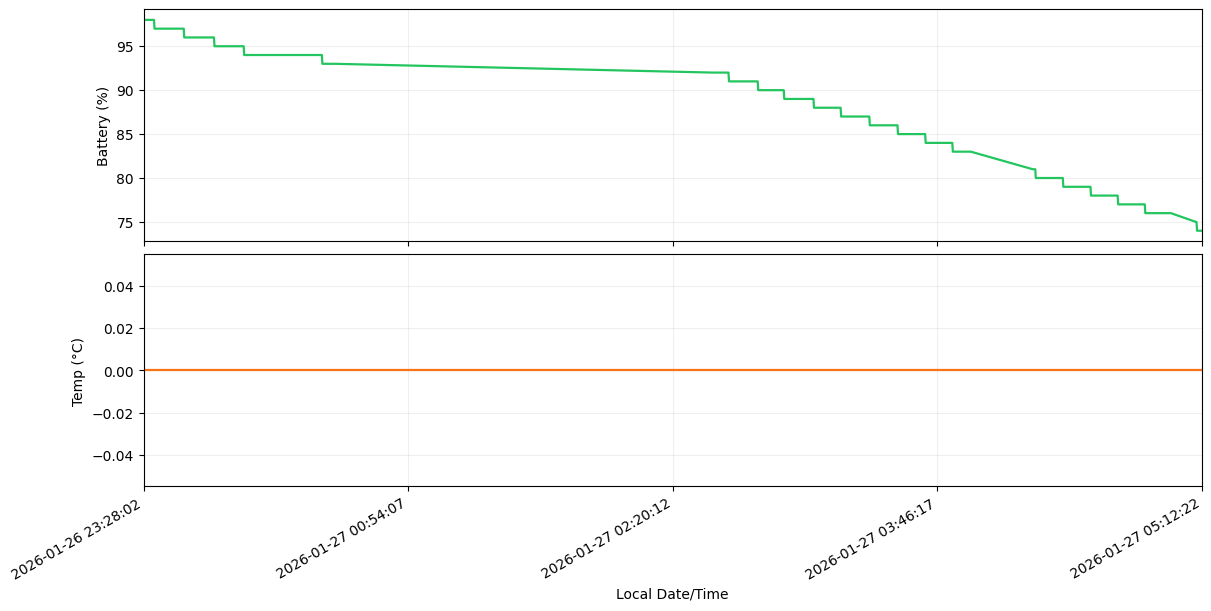

In [5]:
# Telemetry detection + charts (delegates to telemetry_utils)
import telemetry_utils as telemetry

sidecar = {}
if 'exports' in globals() and exports:
    for exp in reversed(exports):
        sc = (exp.get('_sidecar') or {}) if isinstance(exp, dict) else {}
        th = sc.get('TelemetryHistory') if isinstance(sc, dict) else None
        if isinstance(th, dict) and any((th.get(k) or []) for k in ('battery', 'temperature')):
            sidecar = sc
            break
elif 'sidecar' in globals() and isinstance(sidecar, dict):
    sidecar = sidecar

telemetry_df = telemetry.extract_telemetry_history(exports if 'exports' in globals() else sidecar)
print(f"Telemetry history: battery={(telemetry_df['metric'] == 'battery').sum()} temperature={(telemetry_df['metric'] == 'temperature').sum()}")
telemetry.plot_telemetry_history(telemetry_df, fig_width=12)


Motion history rows: 1018923


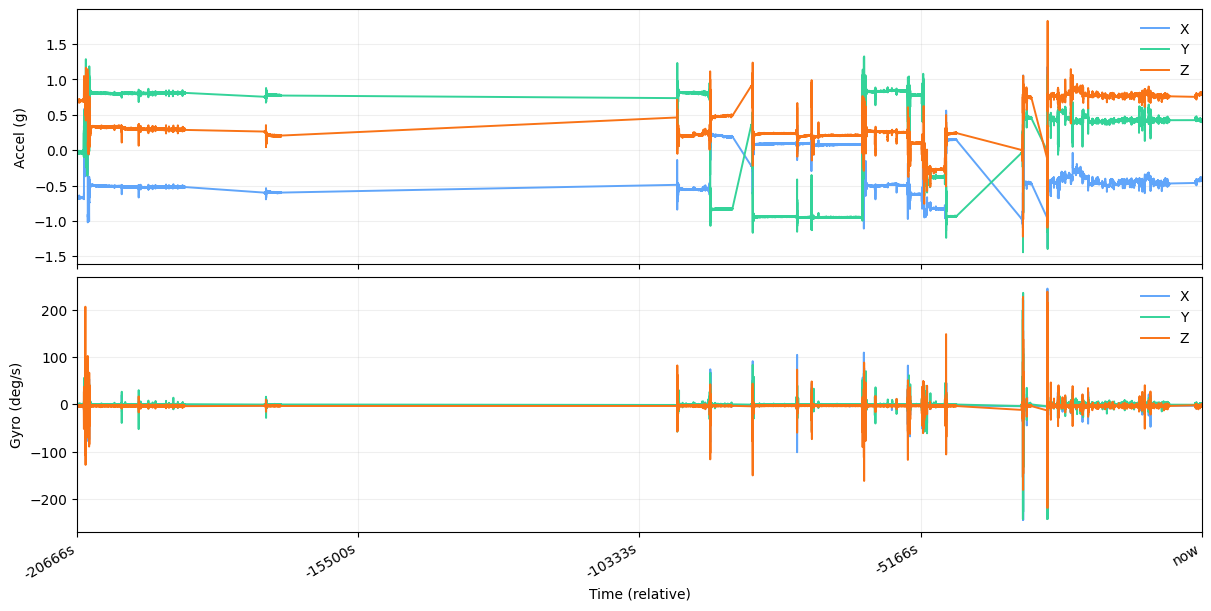

In [6]:
# Motion telemetry charts (accelerometer + gyroscope)
import telemetry_utils as telemetry

motion_df = telemetry.extract_motion_history(exports if 'exports' in globals() else sidecar)
print(f"Motion history rows: {len(motion_df)}")
telemetry.plot_motion_history(motion_df, fig_width=12)


Plotting window: 2026-01-26 23:27:58 PST to 2026-01-27 05:12:25 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:1543: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


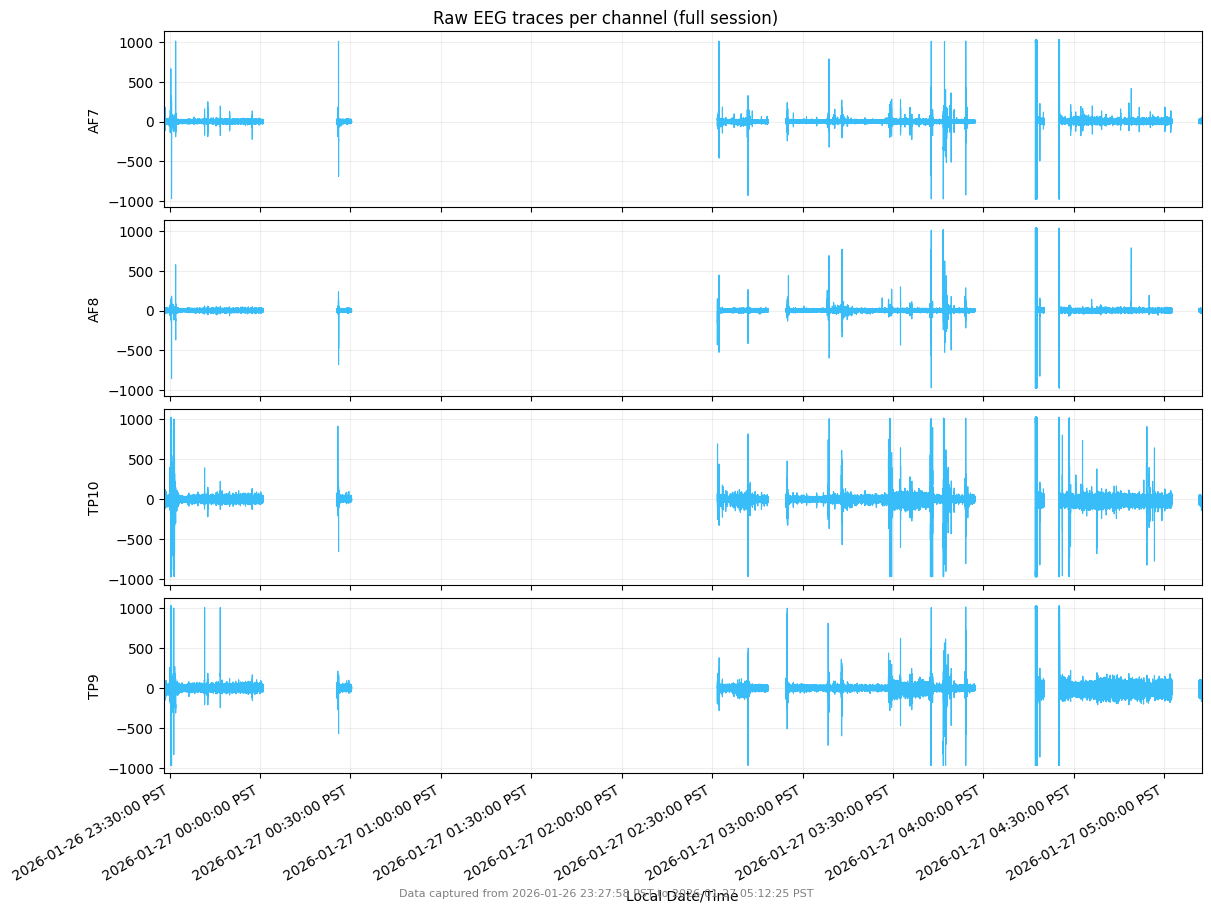

In [7]:
# Raw EEG traces (full session)
EEG_MAX_POINTS = None
EEG_FIG_WIDTH = 12

eeg.plot_raw_traces_per_label(
    exports,
    diag_df=diag_df,
    max_points=EEG_MAX_POINTS,
    fig_width=EEG_FIG_WIDTH,
    title_prefix='EEG',
)


### Artifact Rejection + Metrics

- Purpose: Plot EEG traces with artifact overlays and artifact metric diagnostics.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:503: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


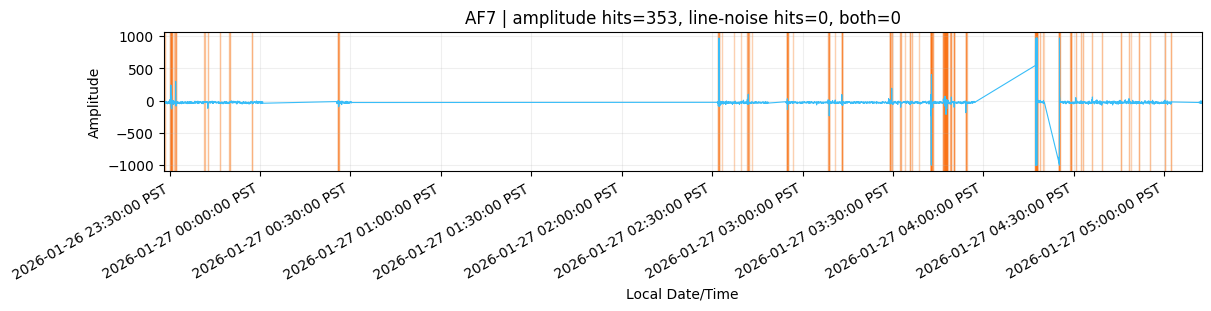

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:503: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


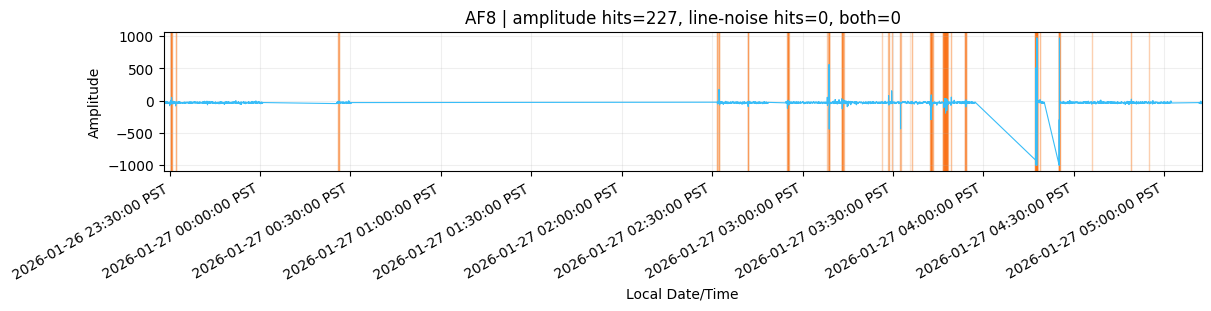

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:503: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


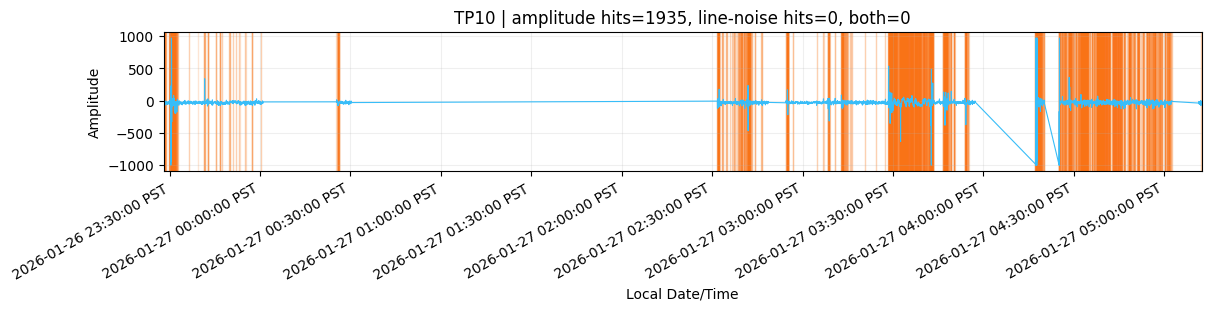

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:503: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


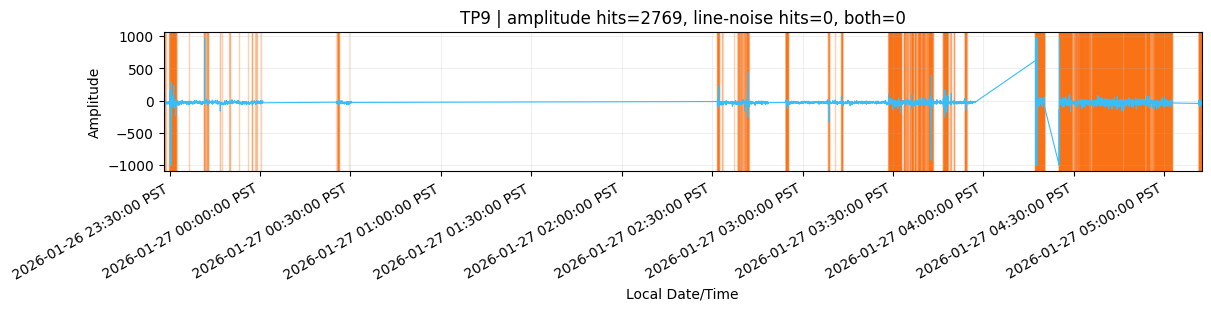

Artifact rates by label (% of windows):
       amplitude_artifact_rate  line_noise_artifact_rate  artifact_rate
label                                                                  
TP9                       29.0                       0.0           29.0
TP10                      20.3                       0.0           20.3
AF7                        3.7                       0.0            3.7
AF8                        2.4                       0.0            2.4


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:580: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


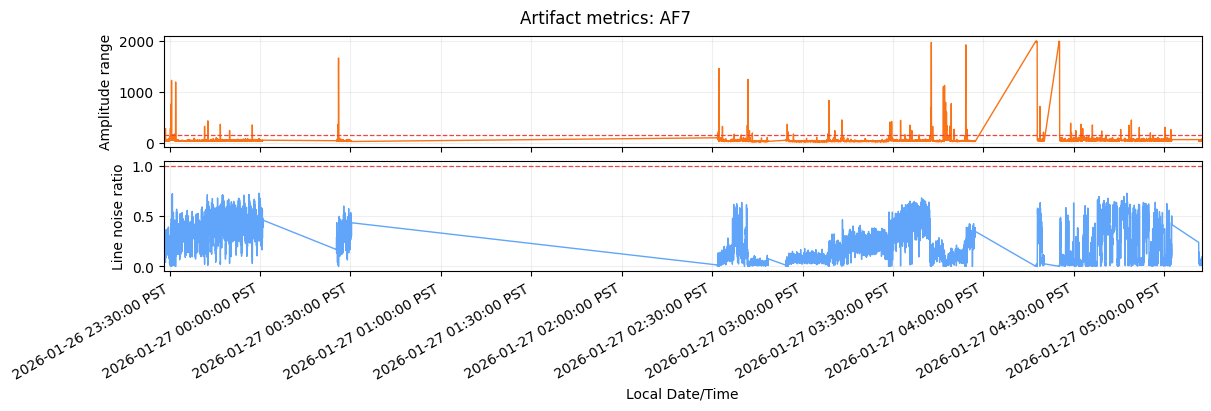

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:580: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


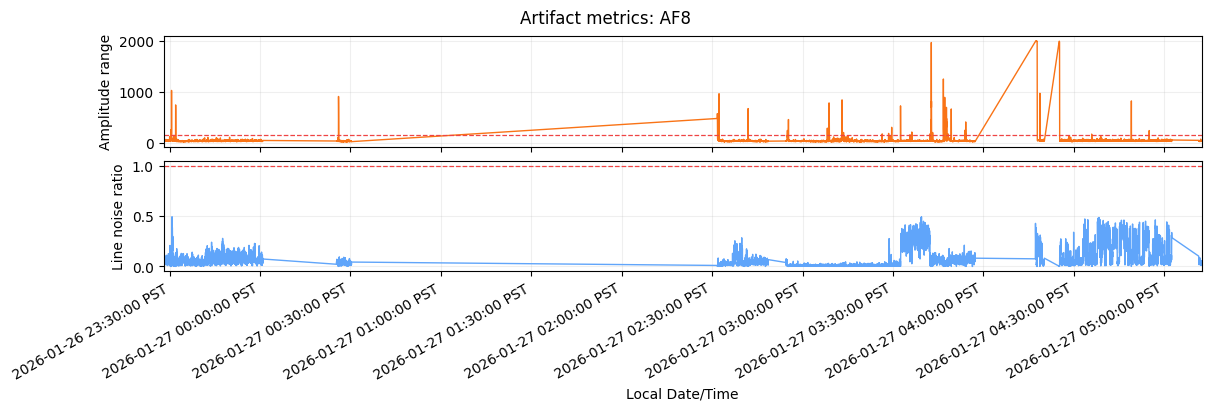

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:580: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


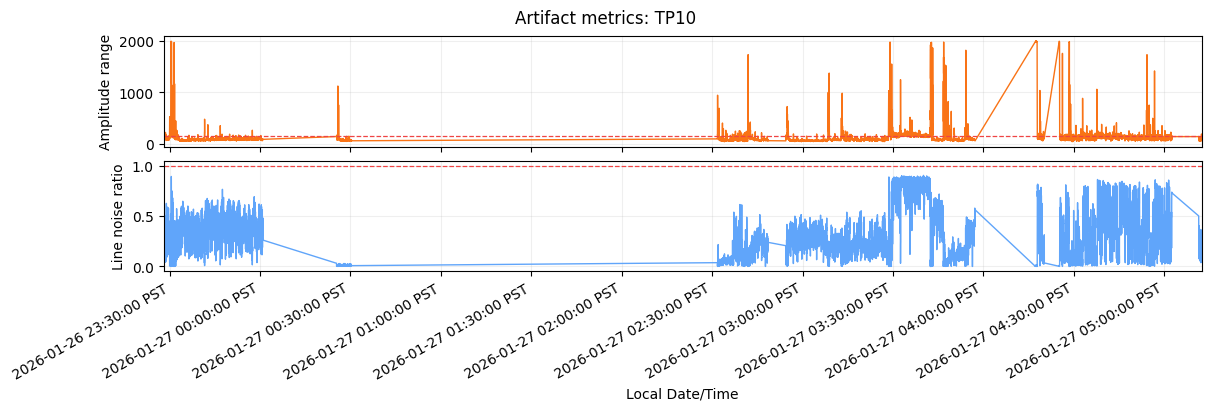

/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:580: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


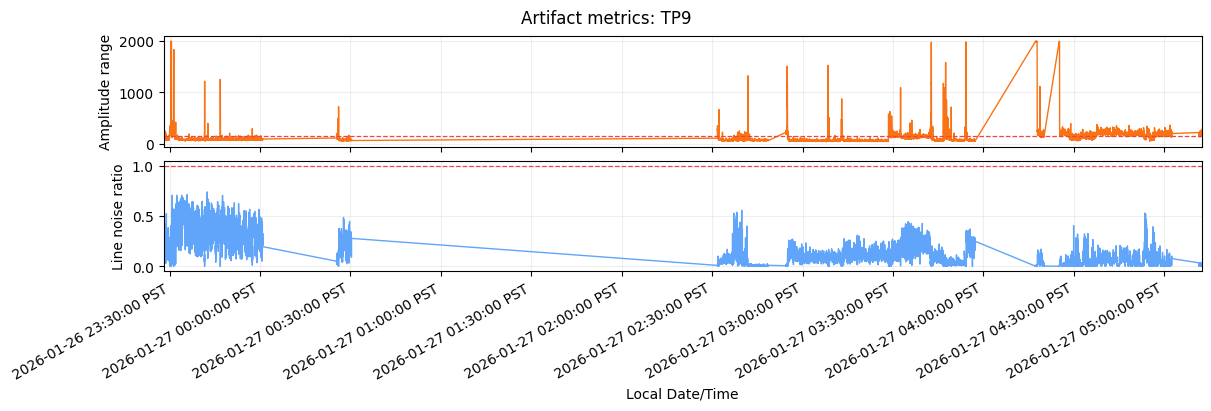

In [8]:
# Artifact rejection overlays + metrics
artifact_df = eeg.plot_artifact_overlays_and_metrics(
    exports,
    diag_df,
    window_sec=ARTIFACT_WINDOW_SEC,
    step_sec=ARTIFACT_STEP_SEC,
    amplitude_range_threshold=AMPLITUDE_RANGE_THRESHOLD,
    line_noise_ratio_threshold=LINE_NOISE_RATIO_THRESHOLD,
    line_noise_hz=LINE_NOISE_HZ,
    line_noise_band_hz=LINE_NOISE_BAND_HZ,
    line_noise_max_hz=LINE_NOISE_MAX_HZ,
    overlay_mode=REJECTION_OVERLAY_MODE,
    overlay_max_windows=REJECTION_OVERLAY_MAX_WINDOWS,
    trace_window_sec=REJECTION_TRACE_WINDOW_SEC,
    trace_max_points=REJECTION_TRACE_MAX_POINTS,
    plot_diagnostics=PLOT_ARTIFACT_DIAGNOSTICS,
)


### Raw PPG Traces
Plots raw PPG channels from the exported TSV files.

### Load PPG Exports

- Purpose: Load PPG exports and print diagnostics.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `ppg_exports` available; skip if missing.
- Resilience: guard against missing channels or insufficient samples.


In [9]:
ppg_exports = eeg.load_ppg_exports(RAW_DIR, pattern='*_ppg.tsv')
if ppg_exports:
    ppg_diag_df = eeg.build_export_diagnostics(ppg_exports)
    eeg.print_export_summary(ppg_diag_df, RAW_DIR)
else:
    ppg_diag_df = None
    print('No PPG exports found in', RAW_DIR)


=== Sample Export Summary ===
RAW_DIR: raw_data
Files: 160
Total channels: 480
Channel labels: ['AMBIENT', 'IR', 'RED']
CapturedAt range: 2026-01-27T07:27:58.913000+00:00 → 2026-01-27T13:15:38.400000+00:00
CaptureEndedAt range: 2026-01-27T07:28:58.897375+00:00 → 2026-01-27T13:16:38.384375+00:00
Sampling rates (Hz): [64.0]
Samples/channel (min/median/max): 3840 / 3840 / 3840
Duration/channel seconds (min/median/max): 60.00 / 60.00 / 60.00
Timestamps present (per-sample): 0/480 channels


### Raw PPG Traces

- Purpose: Plot full-session raw PPG traces for each channel.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `ppg_exports` available; skip if missing.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


Plotting window: 2026-01-26 23:27:58 PST to 2026-01-27 05:16:38 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:1543: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


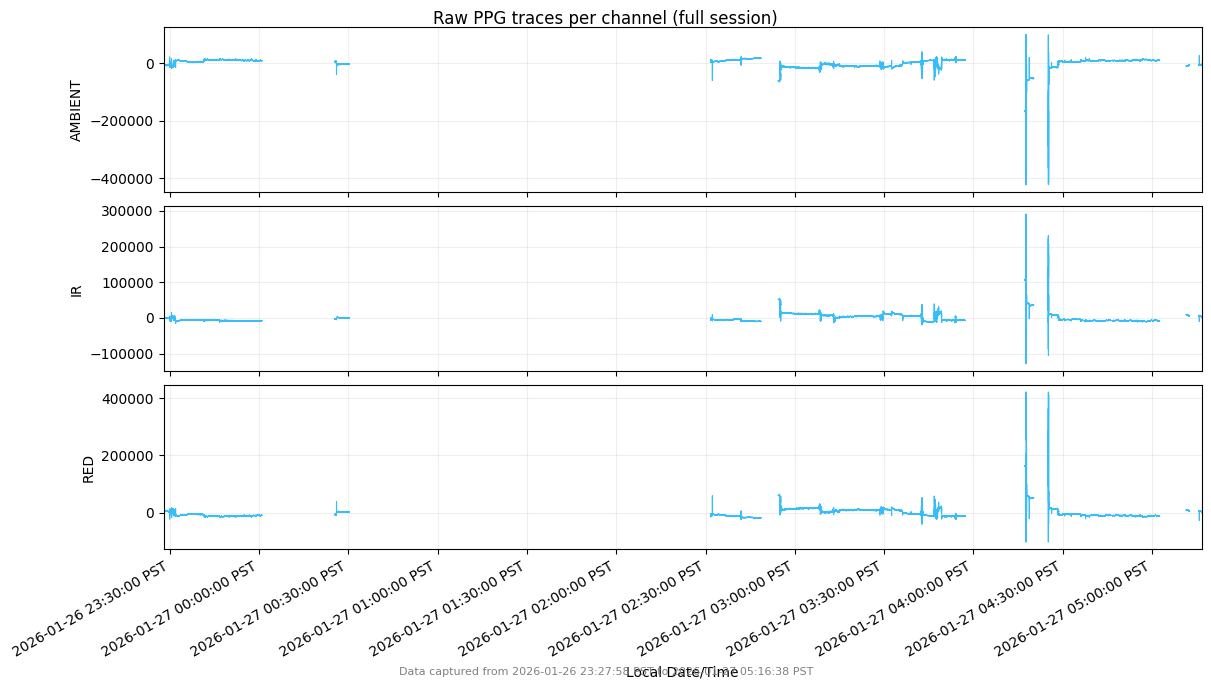

In [10]:
if ppg_exports:
    PPG_WINDOW_SEC = None  # full range
    PPG_MAX_POINTS = None
    PPG_FIG_WIDTH = 12
    eeg.plot_raw_traces_per_label(
        ppg_exports,
        diag_df=ppg_diag_df,
        window_sec=PPG_WINDOW_SEC,  # unused; full range is plotted
        max_points=PPG_MAX_POINTS,
        fig_width=PPG_FIG_WIDTH,
        title_prefix='PPG',
    )
else:
    print('Skipping PPG trace plot (no data).')


### PPG Cardiogram + Heart Rate (15s average)
Processes the combined PPG into a cardiogram-like signal and plots a 15-second averaged HR trend.

### EEG Utilities

- Purpose: Load EEG processing utilities for downstream analysis.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Inputs: `ppg_exports` available; skip if missing.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


SpO2=91.6% R=0.736 PI(IR/Red)=0.0005/0.0004
Estimated HR: 61 bpm


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:1180: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 1000000.
  ax.get_figure().autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 1000000.
  func(*args, **kwargs)
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 1000000.
  fig.canvas.print_figure(bytes_

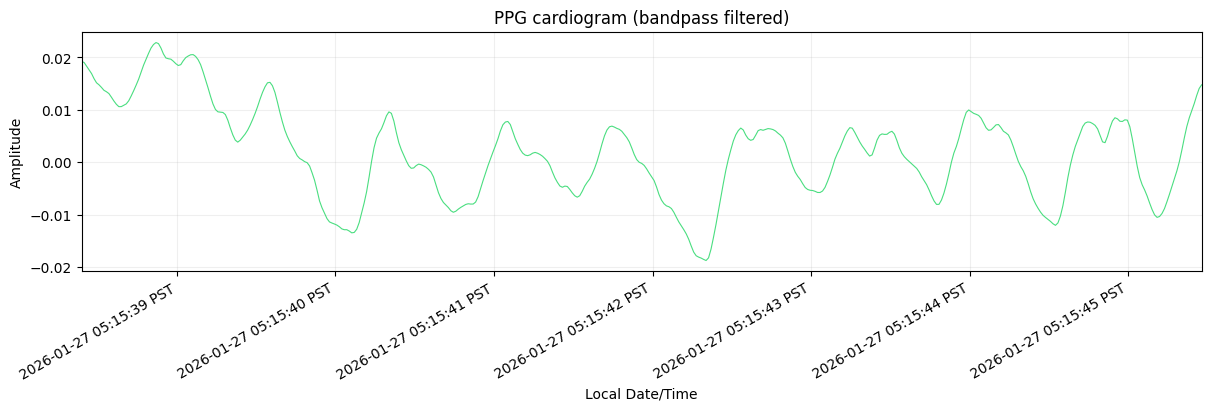

In [11]:
if "eeg" not in globals():
    import sys
    from pathlib import Path
    _utils_dir = Path('notebooks')
    if (_utils_dir / 'eeg_processing_utils.py').exists():
        sys.path.insert(0, str(_utils_dir.resolve()))
    import eeg_processing_utils as eeg

if "ppg_exports" not in globals():
    ppg_exports = eeg.load_ppg_exports(RAW_DIR, pattern='*_ppg.tsv')

if ppg_exports:
    ppg_export = eeg.subtract_ambient_ppg(ppg_exports[-1])
    channels = ppg_export.get('channels', []) or []
    labels = [c.get('label') for c in channels]
    sidecar = ppg_export.get('_sidecar') or {}
    label_map = (sidecar.get('PpgLabelMap') or {}).get('labels') or {}
    mapping = (sidecar.get('PpgLabelMap') or {}).get('mapping') or {}
    if not mapping:
        mapping = eeg.infer_ppg_mapping(labels)
        ir_label = mapping.get('infrared')
        red_label = mapping.get('red')
    else:
        ir_label = label_map.get(str(mapping.get('infrared'))) if isinstance(label_map, dict) else None
        red_label = label_map.get(str(mapping.get('red'))) if isinstance(label_map, dict) else None

    ir = next((c for c in channels if c.get('label') == ir_label), None)
    red = next((c for c in channels if c.get('label') == red_label), None)
    if ir and red:
        ir_samples = np.asarray(ir.get('samples', []) or [], dtype=float)
        red_samples = np.asarray(red.get('samples', []) or [], dtype=float)
        ppg_fs = float(ppg_export.get('samplingRateHz') or 64.0)
        spo2 = eeg.compute_spo2_metrics(ir_samples, red_samples, ppg_fs, window_sec=8.0)
        if spo2:
            print(f"SpO2={spo2['spo2']:.1f}% R={spo2['ratio']:.3f} PI(IR/Red)={spo2['pi_ir']:.4f}/{spo2['pi_red']:.4f}")
        else:
            print('SpO2 unavailable (insufficient signal).')
    else:
        print('PPG IR/Red channels not found for SpO2.')

    combined, ppg_fs = eeg.combine_ppg_channels(ppg_export)
    if combined is None:
        print('No combined PPG data available.')
    else:
        capture_start = eeg.export_capture_start(ppg_export)
        if capture_start is None:
            print('Skipping PPG cardiogram/HR plots (missing capture start for local time).')
        else:
            cardiogram = eeg.build_ppg_cardiogram(combined, ppg_fs, beats=5)
            if cardiogram is not None:
                eeg.plot_cardiogram(
                    cardiogram,
                    ppg_fs,
                    title='PPG cardiogram (bandpass filtered)',
                    start_timestamp=capture_start
                )
            else:
                print('No cardiogram available (peak detection failed).')

            hr_bpm = eeg.compute_ppg_hr(combined, ppg_fs)
            if hr_bpm is None:
                print('No HR estimate available.')
            else:
                print(f'Estimated HR: {hr_bpm:.0f} bpm')
else:
    print('Skipping PPG cardiogram/HR plots (no data).')


In [12]:
# Note: PPG channel labels are used as-is (IR/RED/AMBIENT if provided, otherwise PPG1/PPG2/PPG3).


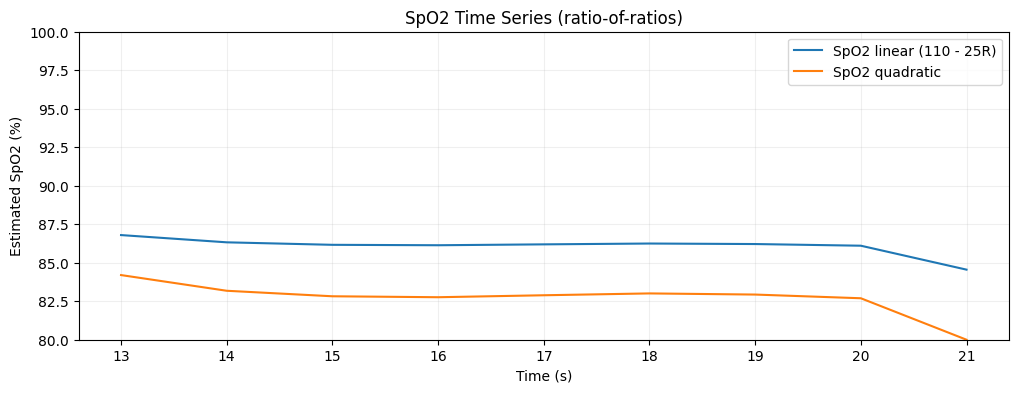

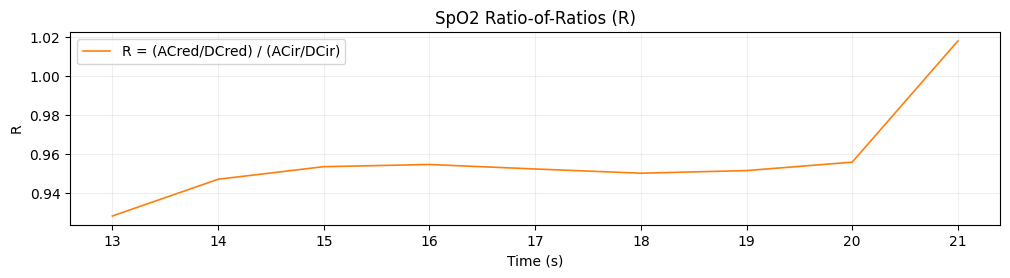

In [13]:
# SpO2 time series plot (delegates processing to ppg_utils)
import numpy as np
import matplotlib.pyplot as plt
import ppg_utils as ppg

sample_rate_hz = float(locals().get('sample_rate_hz', 64))

window_sec = 8
step_sec = 1
window_n = int(window_sec * sample_rate_hz)
step_n = max(1, int(step_sec * sample_rate_hz))

ir = np.asarray(ir_samples, dtype=float)
red = np.asarray(red_samples, dtype=float)
n = min(ir.size, red.size)
ir = ir[-n:]
red = red[-n:]

times = []
spo2_linear = []
spo2_quadratic = []
ratios = []

for end in range(window_n, n + 1, step_n):
    ir_win = ir[end - window_n:end]
    red_win = red[end - window_n:end]
    result = ppg.spo2_ratio_of_ratios(ir_win, red_win, sample_rate_hz=sample_rate_hz)
    t_sec = end / sample_rate_hz
    times.append(t_sec)
    if result.get('ok'):
        ratios.append(result['ratio'])
        spo2_linear.append(result['spo2_linear'])
        spo2_quadratic.append(result['spo2_quadratic'])
    else:
        ratios.append(np.nan)
        spo2_linear.append(np.nan)
        spo2_quadratic.append(np.nan)

plt.figure(figsize=(12, 4))
plt.plot(times, spo2_linear, label='SpO2 linear (110 - 25R)', linewidth=1.5)
plt.plot(times, spo2_quadratic, label='SpO2 quadratic', linewidth=1.5)
plt.ylim(80, 100)
plt.xlabel('Time (s)')
plt.ylabel('Estimated SpO2 (%)')
plt.title('SpO2 Time Series (ratio-of-ratios)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 2.5))
plt.plot(times, ratios, label='R = (ACred/DCred) / (ACir/DCir)', color='tab:orange', linewidth=1.2)
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.title('SpO2 Ratio-of-Ratios (R)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()


### Spectrograms (Per Electrode)

Computes a spectrogram for each channel label and renders them as stacked time–frequency heatmaps.


### Spectrograms

- Purpose: Compute and plot full-session spectrograms per electrode.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


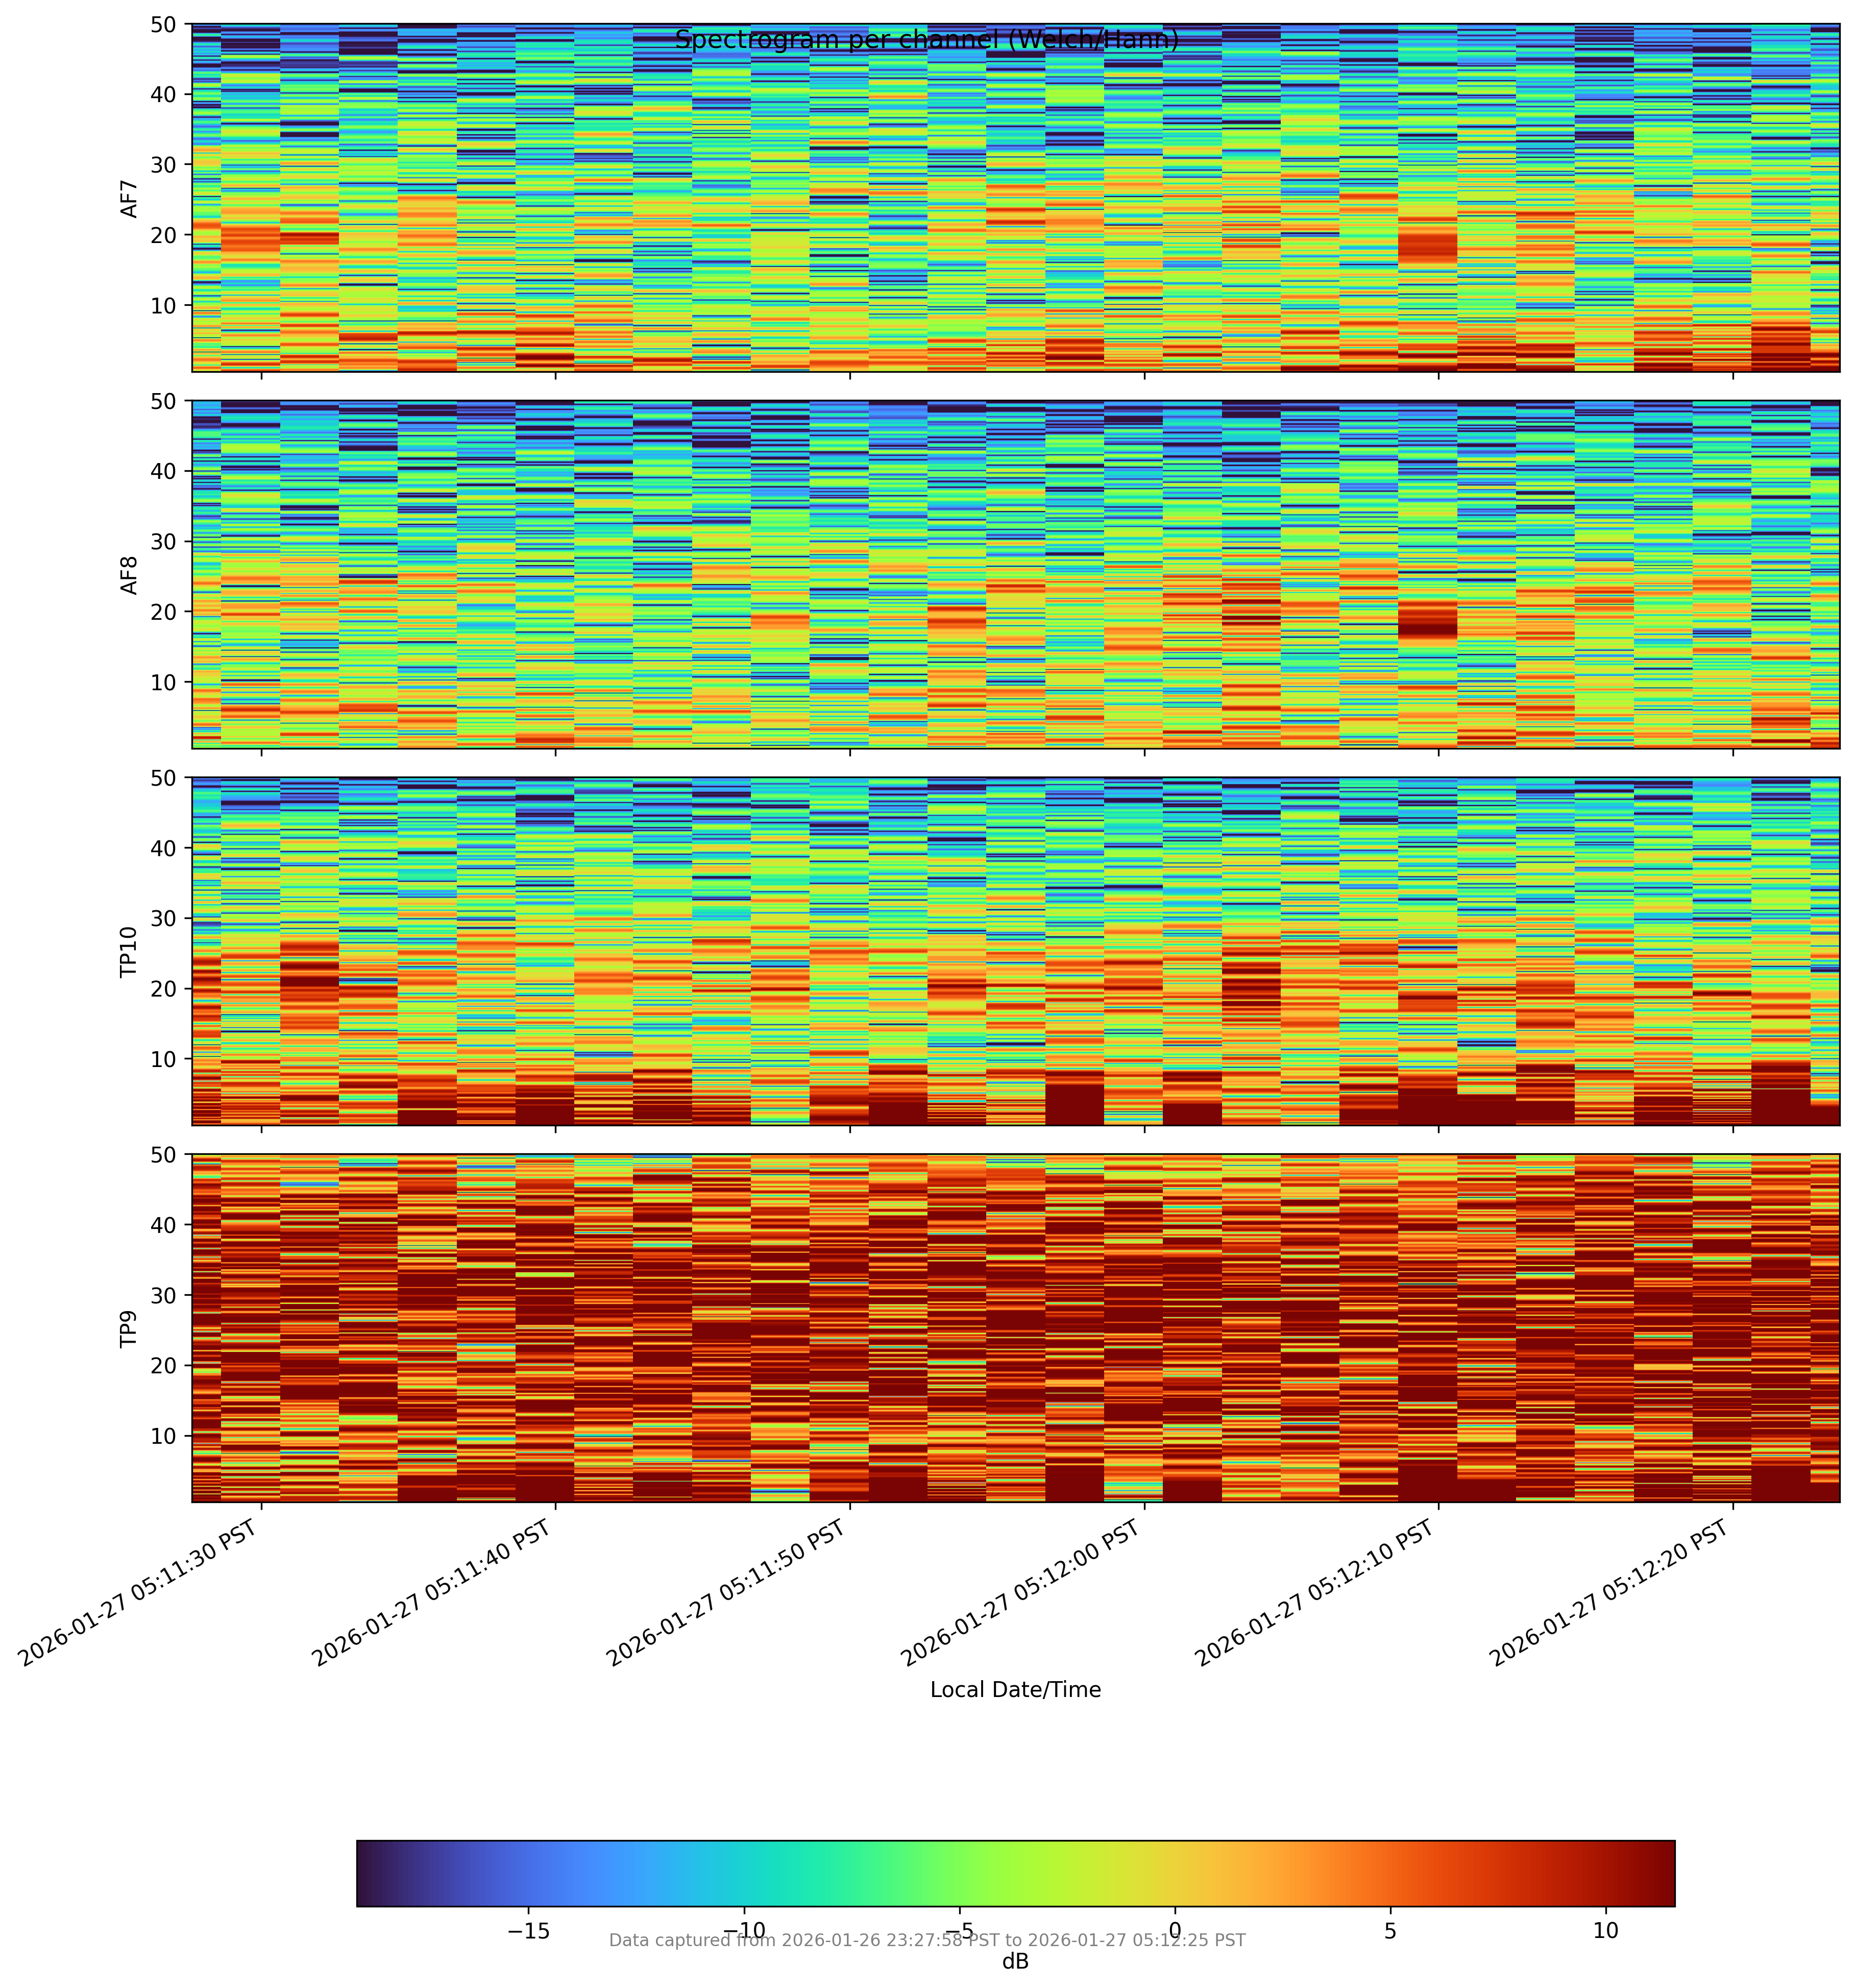

In [14]:
# Spectrograms per electrode channel
MAX_SPECTROGRAM_SEC = None  # full range
# Keep spectrogram windows aligned with band power settings for comparable views.
SPECTROGRAM_NPERSEG = NPERSEG
SPECTROGRAM_NOVERLAP = NOVERLAP
# Note: `nfft` zero-pads (smoother grid) but doesn't add true frequency resolution.
SPECTROGRAM_NFFT = max(4096, SPECTROGRAM_NPERSEG)
SPECTROGRAM_ROW_HEIGHT = 3.2  # inches per channel
SPECTROGRAM_DPI = 300
FIG_WIDTH = 12
eeg.plot_spectrograms_per_label(
    exports,
    diag_df=diag_df,
    max_spectrogram_sec=MAX_SPECTROGRAM_SEC,
    max_freq_hz=50,
    nfft=SPECTROGRAM_NFFT,
    nperseg=SPECTROGRAM_NPERSEG,
    noverlap=SPECTROGRAM_NOVERLAP,
    per_channel_height=SPECTROGRAM_ROW_HEIGHT,
    dpi=SPECTROGRAM_DPI,
    fig_width=FIG_WIDTH,
)


### Band Power Diagrams

Creates band power line charts for each electrode, TP channels combined, AF channels combined, and all channels combined.


### Band Power Diagrams

- Purpose: Compute band power time series and plot per-channel and grouped views.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


Band power plot window for AF7: 2026-01-26 23:28:00 PST to 2026-01-27 05:12:23 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for AF8: 2026-01-26 23:28:00 PST to 2026-01-27 05:12:23 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for TP10: 2026-01-26 23:28:14 PST to 2026-01-27 05:12:23 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for TP9: 2026-01-26 23:28:00 PST to 2026-01-27 05:02:19 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for TP Combined: 2026-01-26 23:28:14 PST to 2026-01-27 05:02:19 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for AF Combined: 2026-01-26 23:28:00 PST to 2026-01-27 05:12:23 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for Left Combined: 2026-01-26 23:28:00 PST to 2026-01-27 05:02:19 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for Right Combined: 2026-01-26 23:28:14 PST to 2026-01-27 05:12:23 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()


Band power plot window for All Combined: 2026-01-26 23:28:14 PST to 2026-01-27 05:02:19 PST


/Users/matthewtippett/github/meditrain/notebooks/eeg_processing_utils.py:2073: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.gcf().autofmt_xdate()
/Users/matthewtippett/.pyenv/versions/3.14.2/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


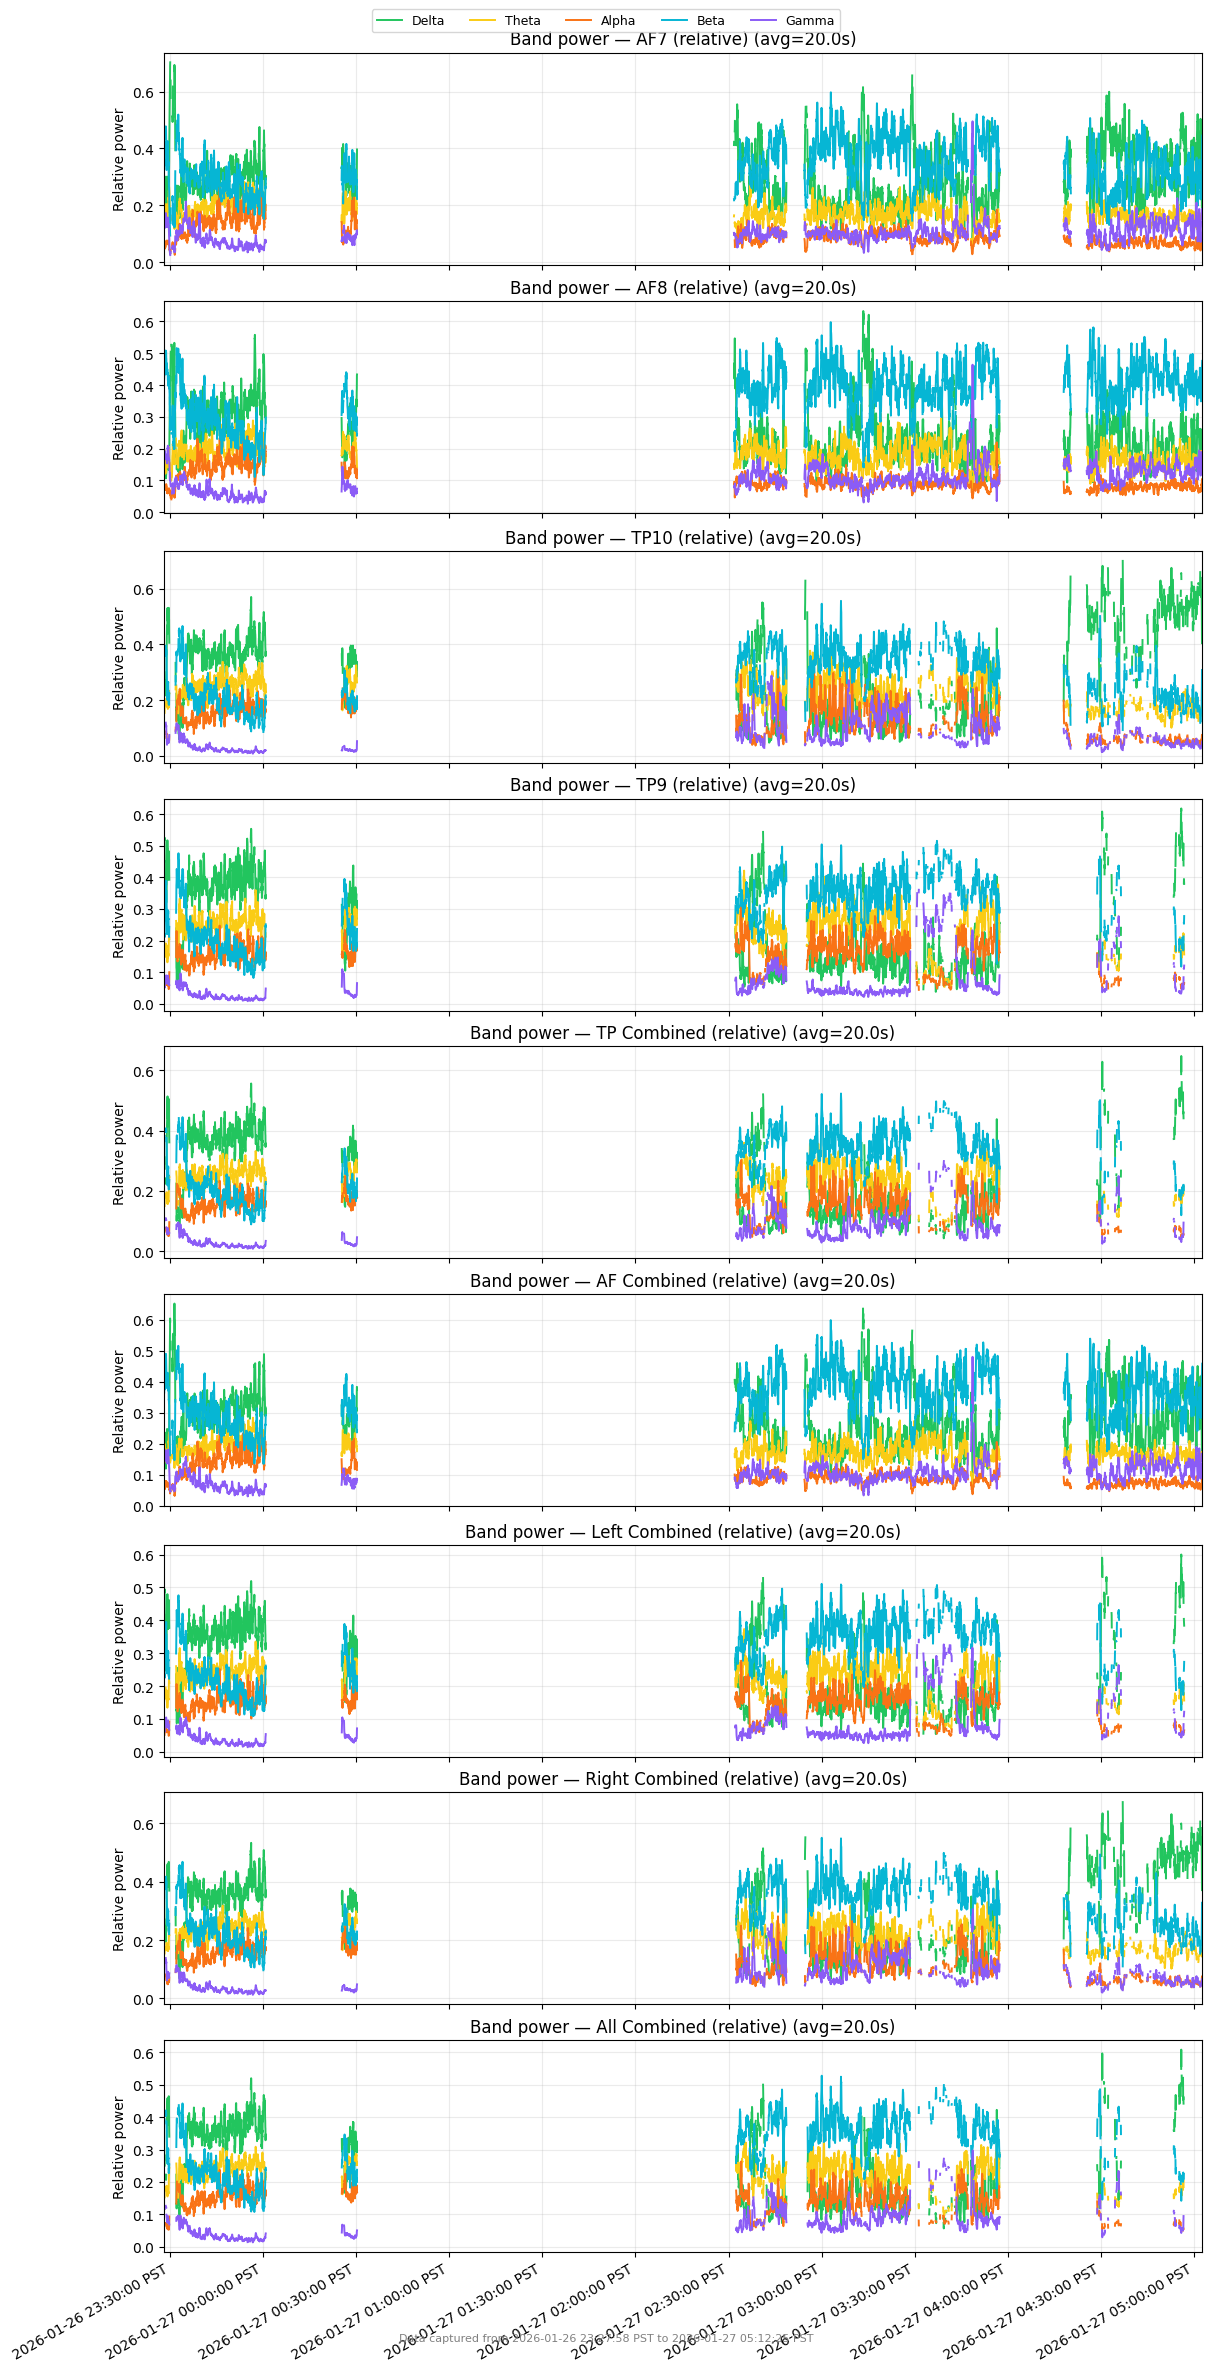

In [15]:
# Band power diagrams: per channel + combined groups
BAND_POWER_AVG_SEC = BAND_POWER_AVG_SEC if 'BAND_POWER_AVG_SEC' in globals() else 180
PLOT_RELATIVE = True
FIG_WIDTH = 12

try:
    _ = eeg.plot_band_power_diagrams(
        exports,
        diag_df,
        avg_sec=BAND_POWER_AVG_SEC,
        relative=PLOT_RELATIVE,
        fig_width=FIG_WIDTH,
        reject_artifacts=BAND_POWER_REJECT_ARTIFACTS,
        amplitude_range_threshold=AMPLITUDE_RANGE_THRESHOLD,
        line_noise_ratio_threshold=LINE_NOISE_RATIO_THRESHOLD,
        line_noise_hz=LINE_NOISE_HZ,
        line_noise_band_hz=LINE_NOISE_BAND_HZ,
        line_noise_max_hz=LINE_NOISE_MAX_HZ,
        nfft=SPECTROGRAM_NFFT,
    )
except ValueError as exc:
    msg = str(exc)
    if msg.startswith('Not enough samples to compute band power'):
        print(f'Band power skipped: {msg}. This is expected with incomplete sample collections.')
    else:
        raise
